In [ ]:
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification,BertConfig
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_df =  pd.read_excel('Training_Data_Set_for_Data_Science_Case_Study.xlsx')

In [ ]:
train_df.head()

,Company Name,Business Description,Industry Classification Tag
0,"ADSOUTH PARTNERS, INC.","Adsouth Partners, Inc. provides advertising ag...",Advertising
1,"Artec Global Media, Inc.","Artec Global Media, Inc., formerly Artec Consu...",Advertising
2,Betawave Corp.,Betawave Corporation provides online marketing...,Advertising
3,BOSTON OMAHA Corp,Boston Omaha Corporation is engaged in the bus...,Advertising
4,Bright Mountain Media Inc,"Bright Mountain Media, Inc. is a digital media...",Advertising


In [ ]:
#train_df.groupby('Industry Classification Tag')['Company Name'].count().plot(kind='bar',figsize=(15,15))

In [ ]:
train_df.isnull().sum()

Company Name                    0
Business Description           23
Industry Classification Tag     0
dtype: int64

In [ ]:
train_df = train_df[~train_df['Business Description'].isnull()]

In [ ]:
train_df.isnull().sum()

Company Name                   0
Business Description           0
Industry Classification Tag    0
dtype: int64

In [ ]:
train_df['Industry Classification Tag'].value_counts()

Regional Banks                        569
Biotechnology                         402
Gold                                  357
Oil & Gas Exploration & Production    224
Application Software                  205
                                     ... 
Technology Distributors                51
Investment Banking & Brokerage         51
Property & Casualty Insurance          50
Internet Services & Infrastructure     50
Real Estate Operating Companies        50
Name: Industry Classification Tag, Length: 62, dtype: int64

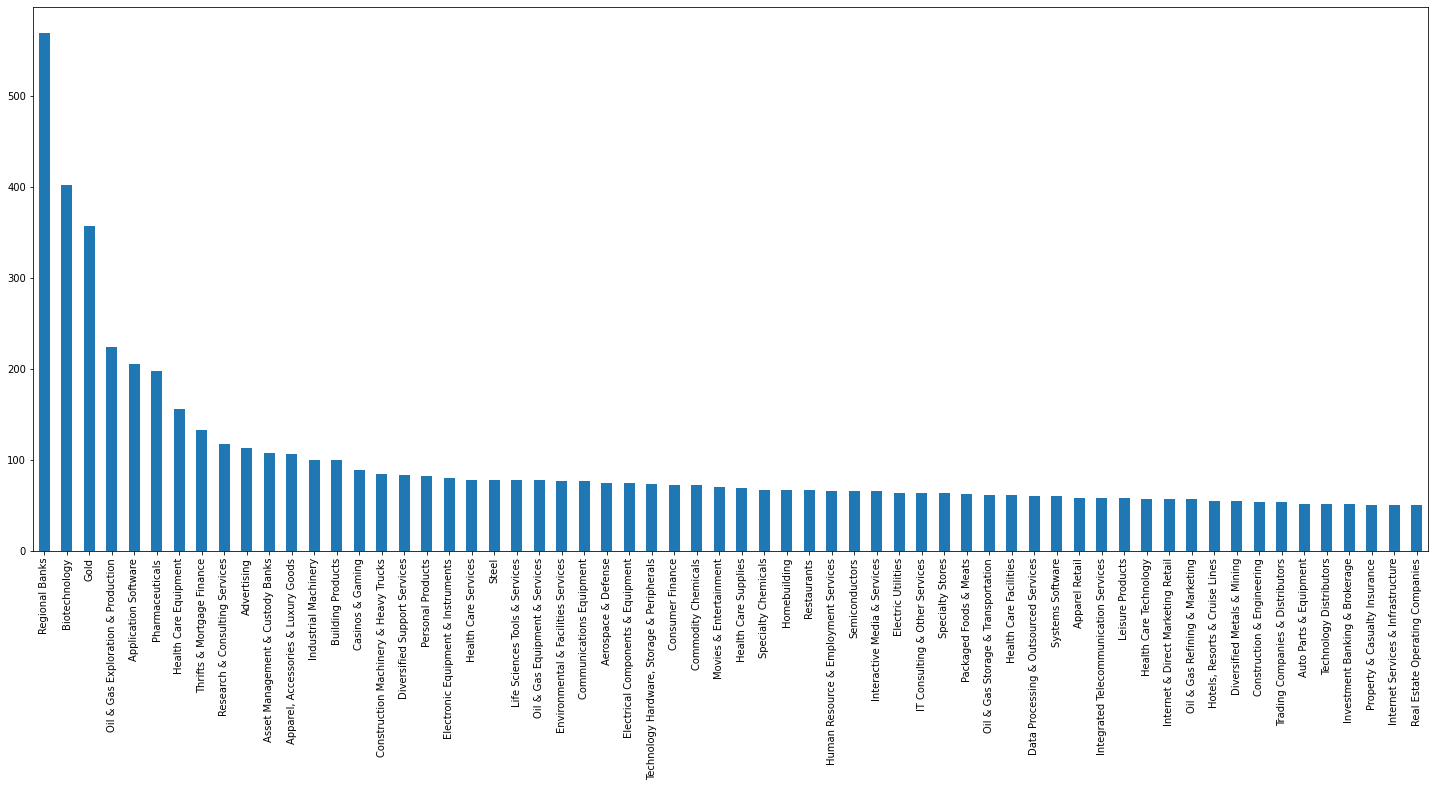

In [ ]:
train_df['Industry Classification Tag'].value_counts().plot(kind='bar',figsize=(25,10))

Top Ten Industry counts

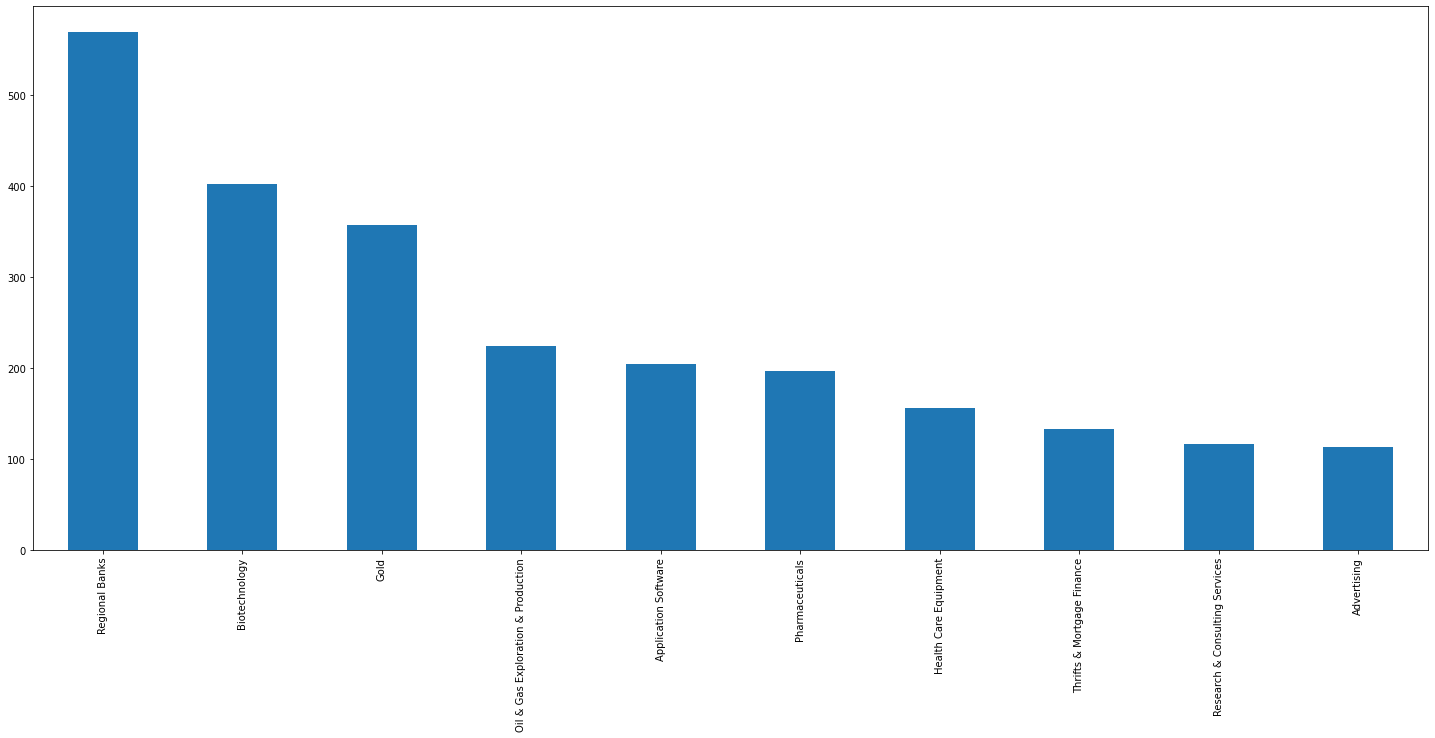

In [ ]:
train_df['Industry Classification Tag'].value_counts()[:10].plot(kind='bar',figsize=(25,10))

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
vocabulary = tokenizer.get_vocab()

print(list(vocabulary.keys())[5000:5020])

['knight', 'lap', 'survey', 'ma', '##ow', 'noise', 'billy', '##ium', 'shooting', 'guide', 'bedroom', 'priest', 'resistance', 'motor', 'homes', 'sounded', 'giant', '##mer', '150', 'scenes']


In [ ]:
train_df['Industry Classification Tag'].unique()

array(['Advertising', 'Aerospace & Defense', 'Apparel Retail',
       'Apparel, Accessories & Luxury Goods', 'Application Software',
       'Asset Management & Custody Banks', 'Auto Parts & Equipment',
       'Biotechnology', 'Building Products', 'Casinos & Gaming',
       'Commodity Chemicals', 'Communications Equipment',
       'Construction & Engineering',
       'Construction Machinery & Heavy Trucks', 'Consumer Finance',
       'Data Processing & Outsourced Services',
       'Diversified Metals & Mining', 'Diversified Support Services',
       'Electric Utilities', 'Electrical Components & Equipment',
       'Electronic Equipment & Instruments',
       'Environmental & Facilities Services', 'Gold',
       'Health Care Equipment', 'Health Care Facilities',
       'Health Care Services', 'Health Care Supplies',
       'Health Care Technology', 'Homebuilding',
       'Hotels, Resorts & Cruise Lines',
       'Human Resource & Employment Services', 'Industrial Machinery',
       'Integ

In [ ]:
len(train_df['Industry Classification Tag'].unique())

62

In [ ]:
le = LabelEncoder()
le.fit(train_df['Industry Classification Tag'])
y = le.transform(train_df['Industry Classification Tag'])

In [ ]:
X = (np.array(train_df['Business Description']))
y = (np.array(y))
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, random_state=42)

In [ ]:
# can be up to 512 for BERT
max_length = 512

# the recommended batches size for BERT are 16,32 ... however on this dataset we are overfitting quite fast 
# and smaller batches work like a regularization. 
# You might play with adding another dropout layer instead.
batch_size = 6

In [ ]:

def convert_example_to_feature(review):
  
  # combine step for tokenization, WordPiece vector mapping and will add also special tokens and truncate reviews longer than our max length
  
  return tokenizer.encode_plus(review, 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                truncation = True,
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [ ]:
# map to the expected input to TFBertForSequenceClassification, see here 
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(X,y):

  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []

  for desc,label in zip(X,y):

    bert_input = convert_example_to_feature(desc)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:
# train dataset
ds_train_encoded = encode_examples(X_train,y_train).shuffle(10000).batch(batch_size)

In [ ]:
# test dataset
ds_test_encoded = encode_examples(X_test,y_test).batch(batch_size)

In [ ]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5

learning_rate = 2e-5

number_of_epochs = 5
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=62)
# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',config = config, training= True)

# classifier Adam recommended
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)

Epoch 1/8
803/803 [==============================] - 400s 498ms/step - loss: 2.7276 - accuracy: 0.4266 - val_loss: 1.9256 - val_accuracy: 0.5983
Epoch 2/8
803/803 [==============================] - 396s 493ms/step - loss: 1.5613 - accuracy: 0.6525 - val_loss: 1.3578 - val_accuracy: 0.6788
Epoch 3/8
803/803 [==============================] - 396s 494ms/step - loss: 1.0164 - accuracy: 0.7748 - val_loss: 1.2064 - val_accuracy: 0.6988
Epoch 4/8
803/803 [==============================] - 396s 493ms/step - loss: 0.6767 - accuracy: 0.8547 - val_loss: 1.1413 - val_accuracy: 0.7079
Epoch 5/8
803/803 [==============================] - 396s 493ms/step - loss: 0.4491 - accuracy: 0.9043 - val_loss: 1.1740 - val_accuracy: 0.6921
Epoch 6/8
803/803 [==============================] - 396s 493ms/step - loss: 0.2918 - accuracy: 0.9429 - val_loss: 1.1040 - val_accuracy: 0.7303
Epoch 7/8
803/803 [==============================] - 396s 493ms/step - loss: 0.1854 - accuracy: 0.9655 - val_loss: 1.1998 - val_ac

In [ ]:
# map to the expected input to TFBertForSequenceClassification, see here 
def map_example_to_dict_predict(input_ids, attention_masks, token_type_ids):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }

def encode_examples_predict(X):

  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  #label_list = []

  for desc in X:

    bert_input = convert_example_to_feature(desc)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    #label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list)).map(map_example_to_dict_predict)

In [ ]:
predict_ds_train = encode_examples_predict(train_df['Business Description']).batch(batch_size)

In [ ]:
#model.evaluate(ds_train_encoded)
yhat_classes = model.predict(predict_ds_train)

In [ ]:
yhat = np.argmax(yhat_classes[0], axis=1)


In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y, yhat)
print('Accuracy: %f' % accuracy)

Accuracy: 0.936068


In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y, yhat,average='weighted')
print('Precision: %f' % precision)


Precision: 0.937875


In [ ]:
# recall: tp / (tp + fn)
recall = recall_score(y, yhat,average='weighted')
print('Recall: %f' % recall)


Recall: 0.936068


In [ ]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y, yhat,average='weighted')
print('F1 score: %f' % f1)

F1 score: 0.935908


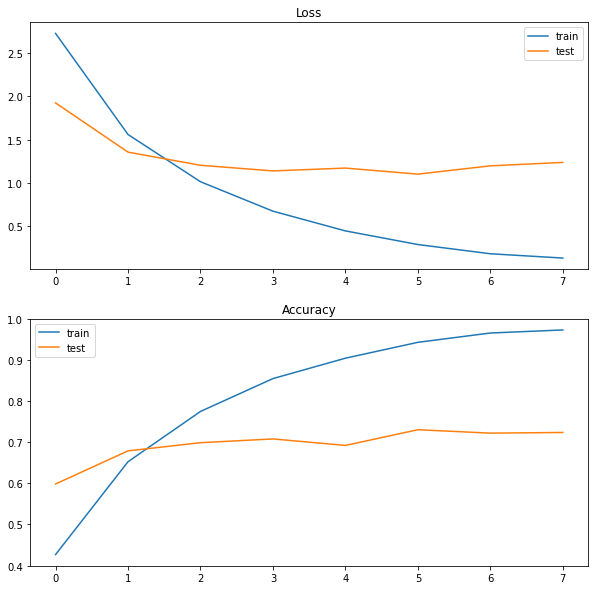

In [ ]:
# plot loss during training
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Loss')
plt.plot(bert_history.history['loss'], label='train')
plt.plot(bert_history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(bert_history.history['accuracy'], label='train')
plt.plot(bert_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
test_df =  pd.read_excel('Testing_Data_for_Data_Science_Case_Stduy.xlsx')

In [ ]:
test_df.head()

,Company,Business Description
0,3rd Rock Multimedia Ltd,3rd Rock Multimedia Limited is an India-based ...
1,Andhra Petrochemicals Ltd,The Andhra Petrochemicals Limited is an India-...
2,Force Motors Ltd,Force Motors Limited is a holding company. The...
3,Diamines And Chemicals Ltd,Diamines and Chemicals Limited is a holding co...
4,Insilco Ltd,Insilco Limited is engaged in manufacturing an...


In [ ]:
test_df.isnull().any()

Company                 False
Business Description    False
dtype: bool

In [ ]:
predict_ds = encode_examples_predict(test_df['Business Description']).batch(batch_size)

In [ ]:
results = model.predict(predict_ds)
prediction = np.argmax(results[0], axis=1)
labels = le.inverse_transform(prediction)

In [ ]:
results[0].shape

(772, 62)

In [ ]:
test_df['Industry'] = labels

In [ ]:
test_df.head(10)

,Company,Business Description,Industry
0,3rd Rock Multimedia Ltd,3rd Rock Multimedia Limited is an India-based ...,Movies & Entertainment
1,Andhra Petrochemicals Ltd,The Andhra Petrochemicals Limited is an India-...,Commodity Chemicals
2,Force Motors Ltd,Force Motors Limited is a holding company. The...,Construction Machinery & Heavy Trucks
3,Diamines And Chemicals Ltd,Diamines and Chemicals Limited is a holding co...,Specialty Chemicals
4,Insilco Ltd,Insilco Limited is engaged in manufacturing an...,Specialty Chemicals
5,Integrated Financial Services Ltd,Integrated Financial Services Limited is an In...,Asset Management & Custody Banks
6,Ion Exchange (India) Ltd,Ion Exchange (India) Limited is engaged in wat...,Industrial Machinery
7,Kinetic Engineering Ltd,Kinetic Engineering Limited is an India-based ...,Auto Parts & Equipment
8,Lords Chloro Alkali Limited(NDA),Lords Chloro Alkali Limited is engaged in manu...,Commodity Chemicals
9,National Peroxide Ltd,National Peroxide Limited is a manufacturer of...,Commodity Chemicals


In [ ]:
test_df.to_excel('Output.xlsx')

Few observations below:
1. Above model is not a optimsed one. It is slightly overfitted with 8 epochs. 
2. Class Imbalance is not taken care here
3. The entire network could be replaced with a combination of DistilBert model and a Logisctic regression model 
4. Accuracy on the test data could be imporved by more fine tuning of the model.
5. There are no descriptions on the above code

NB: I couldn't manage to any optimizations on the above model, since I was running out of time. 